<a href="https://colab.research.google.com/github/rahiakela/machine-learning-research-and-practice/blob/main/hands-on-machine-learning-with-scikit-learn-keras-and-tensorflow/9-unsupervised-learning-techniques/01_clustering_fundamental.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Clustering Fundamental

Although most of the applications of Machine Learning today are based on supervised learning (and as a result, this is where most of the investments go to), the vast majority of the available data is unlabeled: we have the input features $X$, but we do not have the labels $y$.

In this notebook we will look at a few more unsupervised learning tasks
and algorithms:

* **Clustering**-The goal is to group similar instances together into clusters.
* **Anomaly detection**-The objective is to learn what “normal” data looks like, and then use that to detect abnormal instances.
* **Density estimation**-This is the task of estimating the probability density function (PDF) of the random process that generated the dataset.

There is no universal definition of what a cluster is: it really depends on the context,
and different algorithms will capture different kinds of clusters. 

Some algorithms look for instances centered around a particular point, called a centroid. 

Others look for continuous regions of densely packed instances: these clusters can take on any shape. 

Some algorithms are hierarchical, looking for clusters of clusters. And the list goes on.

There are two popular clustering algorithms:

* K-Means
* DBSCAN

And these are the some of their applications, such as nonlinear dimensionality
reduction, semi-supervised learning, and anomaly detection.

##Setup

In [1]:
# Common imports
import numpy as np
import os
from timeit import timeit

from sklearn.mixture import GaussianMixture
from sklearn.mixture import BayesianGaussianMixture
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AgglomerativeClustering

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.datasets import load_iris
from sklearn.datasets import make_blobs
from sklearn.datasets import load_digits
from sklearn.datasets import make_moons

from scipy.stats import norm

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.image import imread
from matplotlib.ticker import FixedLocator, FixedFormatter
from matplotlib.colors import LogNorm
from matplotlib.patches import Polygon

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

Let's load iris dataset.

In [2]:
data = load_iris()
X = data.data
y = data.target
data.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

##Clustering

The clustering is the task of identifying similar instances and assigning
them to clusters, or groups of similar instances.

Just like in classification, each instance gets assigned to a group. However, unlike classification,
clustering is an unsupervised task.



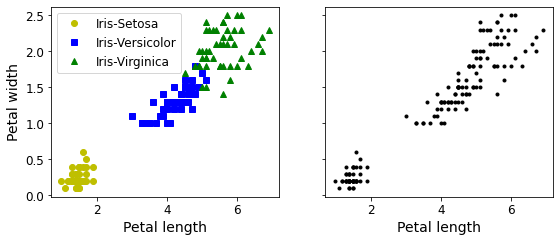

In [3]:
plt.figure(figsize=(9, 3.5))

plt.subplot(121)
plt.plot(X[y==0, 2], X[y==0, 3], "yo", label="Iris-Setosa")
plt.plot(X[y==1, 2], X[y==1, 3], "bs", label="Iris-Versicolor")
plt.plot(X[y==2, 2], X[y==2, 3], "g^", label="Iris-Virginica")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(fontsize=12)

plt.subplot(122)
plt.scatter(X[:, 2], X[:, 3], c="k", marker=".")
plt.xlabel("Petal length", fontsize=14)
plt.tick_params(labelleft=False)

plt.show()

On the right is the same dataset, but without the labels, so you cannot use a
classification algorithm anymore. 

This is where clustering algorithms step in: many of
them can easily detect the lower-left cluster. 

It is also quite easy to see with our own
eyes, but it is not so obvious that the upper-right cluster is composed of two distinct sub-clusters.

But the dataset has two additional features (sepal length and
width), not represented here, and clustering algorithms can make good use of all features, so in fact they identify the three clusters fairly well.

A Gaussian mixture model (explained below) can actually separate these clusters pretty well (using all 4 features: petal length & width, and sepal length & width).



In [5]:
y_pred= GaussianMixture(n_components=3, random_state=42).fit(X).predict(X)
mapping = np.array([2, 0, 1])
y_pred = np.array([mapping[cluster_id] for cluster_id in y_pred])

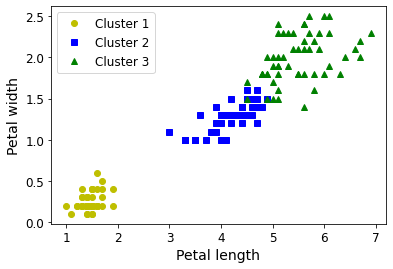

In [6]:
plt.plot(X[y_pred==0, 2], X[y_pred==0, 3], "yo", label="Cluster 1")
plt.plot(X[y_pred==1, 2], X[y_pred==1, 3], "bs", label="Cluster 2")
plt.plot(X[y_pred==2, 2], X[y_pred==2, 3], "g^", label="Cluster 3")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=12)
plt.show()

And using a Gaussian mixture model, only 5 instances out of 150 are assigned to the wrong cluster.

In [7]:
np.sum(y_pred==y)

145

In [8]:
np.sum(y_pred==y) / len(y_pred)

0.9666666666666667

##K-Means